## Testing SecML poisoning implementation

The primary problem is adjusting the PGD-LS optimizer hyperparameters. Attempted: trial and error, scipy minimization using BFGS.

Robustness might be a good thing to measure here? I think I had concerns about using the same measure for robustness as learning though that wouldn't be happening in this case...

I also want to measure how often the oracled point selected by the poisoning algorithm is the 'bad' class. This could give an explanation for why it's not performing that well? If it's always the good expected class then you don't gain much new knowledge, though you may gain robustness.

In [5]:
from functools import lru_cache, partial
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import scipy
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, plot_dataset_2D
from tqdm.auto import tqdm
from sklearn import svm, tree, metrics as skmetrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from art.metrics import empirical_robustness
from joblib import delayed, Parallel
from modAL import batch

from libdatasets import *
from librun import run, plot
from libadversarial import poison_secml, random_synthesis, meshgrid_synthesis, uncertainty_synthesis, halfspace_synthesis
from libactive import active_split, MyActiveLearner
from libutil import ProgressParallel

In [4]:
datasets = {
    "synthetic": lambda: lru_cache(generateData_twoPills_2D)(dataset_size=1000),
    #"car": lambda: lru_cache(car)(),
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
}

In [3]:
def stopping_func(learner, metrics):
    return learner.X_training.shape[0] > 400

### Synthetic data animations, new solver params

In [101]:
import libactive; reload(libactive); from libactive import MyActiveLearner
import libplot; reload(libplot)
import libadversarial; reload(libadversarial); from libadversarial import poison_secml
import libutil; reload(libutil)

X, y = generateData_twoPills_2D(dataset_size=1000)
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.05)

solver_params = {
    'eta': 0.1,
    'eta_min': None,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-4
}

query_methods = {
    "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0), solver_params=solver_params),
}

oracle = svm.SVC(kernel='linear')
oracle.fit(X, y)

for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
    metrics = Parallel()(delayed(lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: 
        MyActiveLearner(animate=True, poison=True, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0)).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func)
    )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method) for i in range(1))[0].frame

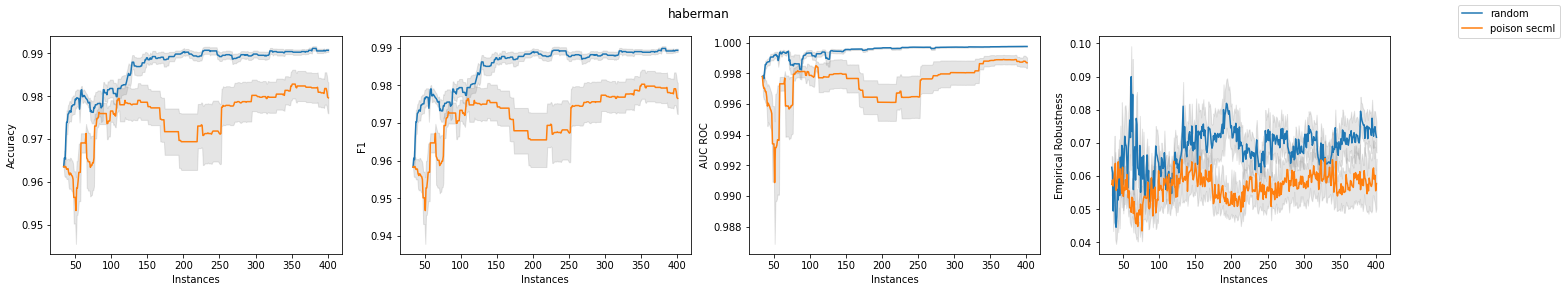

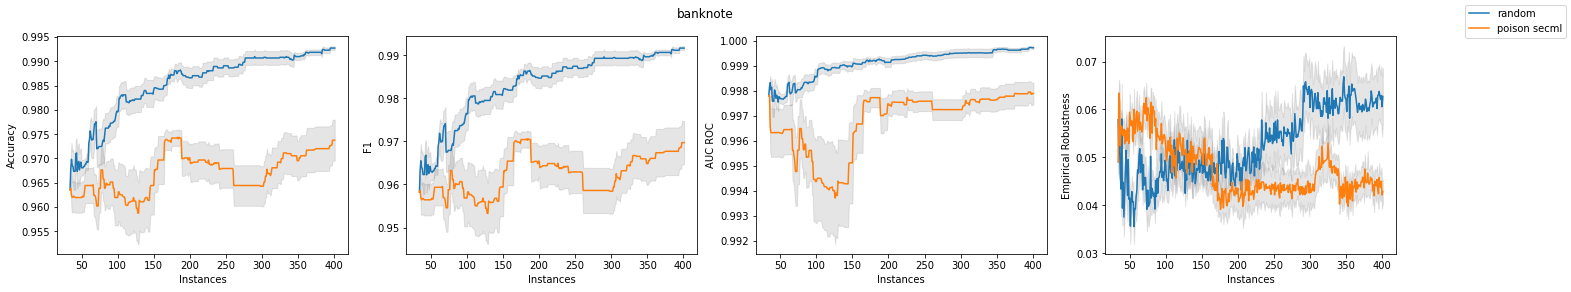

In [8]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0), solver_params=solver_params),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)

    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func, track_flips=True)
            )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv")
        stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
                
    fig.legend()

Empirical robustness doesn't seem to improve with the poisoning query strategy. Dissapointing and somewhat surprising.

haberman

```
193 of 367 had equal oracle and poison attack labels
201 of 367 had equal oracle and poison attack labels
183 of 367 had equal oracle and poison attack labels
189 of 367 had equal oracle and poison attack labels
181 of 367 had equal oracle and poison attack labels
199 of 367 had equal oracle and poison attack labels
175 of 367 had equal oracle and poison attack labels
187 of 367 had equal oracle and poison attack labels
201 of 367 had equal oracle and poison attack labels
191 of 367 had equal oracle and poison attack labels
```

banknote
```
203 of 367 had equal oracle and poison attack labels
195 of 367 had equal oracle and poison attack labels
172 of 367 had equal oracle and poison attack labels
186 of 367 had equal oracle and poison attack labels
198 of 367 had equal oracle and poison attack labels
174 of 367 had equal oracle and poison attack labels
209 of 367 had equal oracle and poison attack labels
187 of 367 had equal oracle and poison attack labels
186 of 367 had equal oracle and poison attack labels
200 of 367 had equal oracle and poison attack labels
```

This is higher than I expected, I thought that most of the oracle labels would be the unsurprising case due to the relatively poor performance of the query strategy.

## Optimal solver parameter estimation

In [146]:
X, y = haberman()
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)

In [151]:
query_methods = {
    "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
    "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0)),
}

oracle = svm.SVC(kernel='linear')
oracle.fit(X, y)

def func(x, log=None):
    eta, eps = x[0], x[1]
    rand_metrics = MyActiveLearner().active_learn_query_synthesis(X_labelled, y_labelled, lambda x: oracle.predict(x), X_test, y_test, query_methods['random'], stopping_func)
    rand_metrics.frame.to_csv(f"Experiments/experiment_synthesis_param_optimization_dataset_{dataset_name}_method_random_eta_{eta}_eps_{eps}.csv")
    
    solver_params = {
        'eta': eta,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': eps
    }
    
    poison_metrics = MyActiveLearner().active_learn_query_synthesis(X_labelled, y_labelled, lambda x: oracle.predict(x), X_test, y_test, partial(query_methods['poison secml'], solver_params=solver_params), stopping_func)
    poison_metrics.frame.to_csv(f"Experiments/experiment_synthesis_param_optimization_dataset_{dataset_name}_method_poison_eta_{eta}_eps_{eps}.csv")

    # minimize this
    score = skmetrics.auc(rand_metrics.frame['x'], rand_metrics.frame.iloc[:,1])-skmetrics.auc(poison_metrics.frame['x'], poison_metrics.frame.iloc[:,1])
    
    if log is not None:
        log.write(f"{eta},{eps},{score}\n")
    
    return score

with open("optimize_log.txt", "w", buffering=1) as f:
    scipy.optimize.minimize(partial(func, log=f), x0=[0.1, 1e-4], method='BFGS', options={"eps": [0.1, 0.001]})

In [152]:
eta=0.3297953991427548
eps=0.7261519961245426

## Uncertainty query synthesis

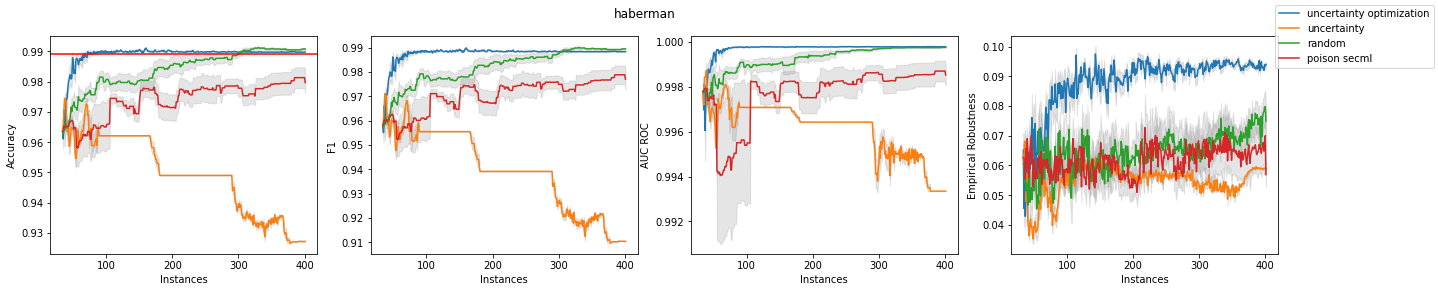

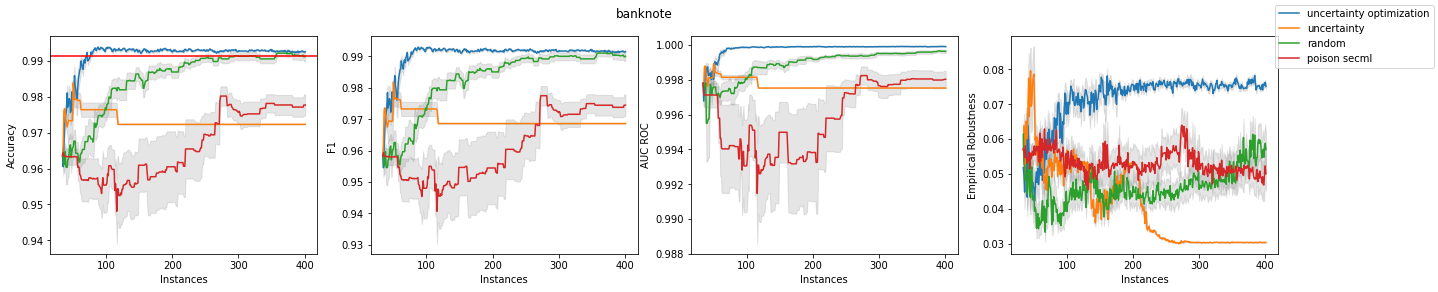

In [20]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0), solver_params=solver_params),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)

    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=3, total=10, desc=f"Run", leave=False)(
            delayed(
                lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func, track_flips=True)
            )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv")
        stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend()

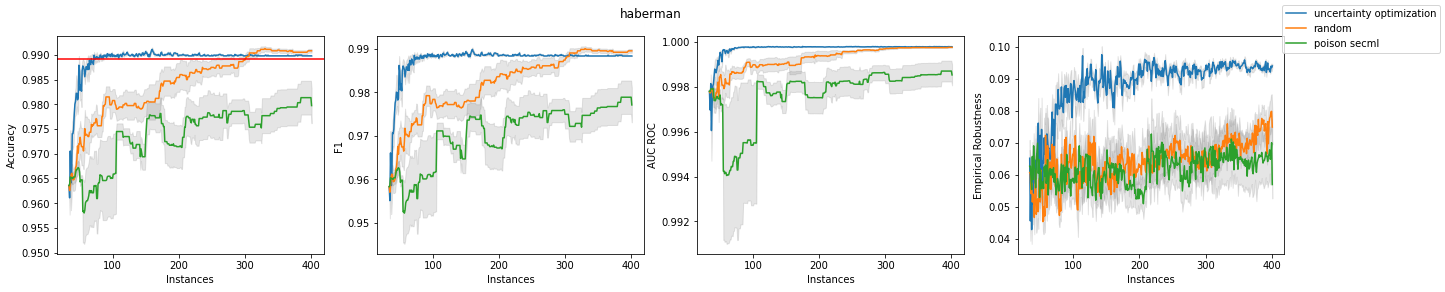

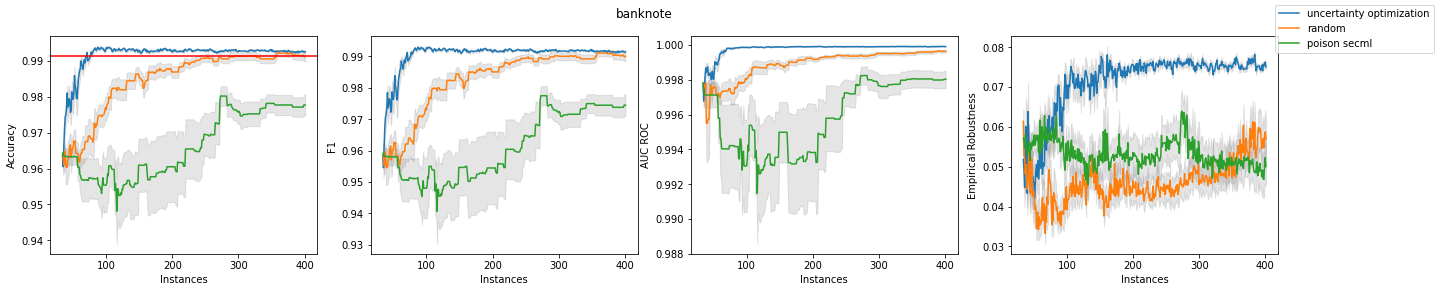

In [5]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0), solver_params=solver_params),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv", index_col=0)
        stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv", index_col=0)
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend()

I wonder how it compares to the uncertainty implementation in https://www-sciencedirect-com.ezproxy.auckland.ac.nz/science/article/pii/S0925231214008145.